In [2]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'

In [5]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)

Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [6]:
# Initialize a dictionary to store file paths for each category
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Iterate over the dataset folders (Bonafide, Spoofed_TTS, Spoofed_Tacotron)
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        # Handle Bonafide folder with Part 1 and Part 2 subfolders
        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    file_path = os.path.join(part_path, file)
                    if file.endswith('.wav'):  # Check if it's a valid audio file
                        audio_files[category].append(file_path)

        # Handle Spoofed_TTS and Spoofed_Tacotron (assuming these don't have parts)
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                file_path = os.path.join(speaker_path, file)
                if file.endswith('.wav'):  # Check if it's a valid audio file
                    audio_files[category].append(file_path)

# Check the loaded audio files
print("Bonafide files:", audio_files['Bonafide'])
print("Spoofed_TTS files:", audio_files['Spoofed_TTS'])
print("Spoofed_Tacotron files:", audio_files['Spoofed_Tacotron'])

Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 213668.06it/s]

Bonafide files: ['/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/10.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/105.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/103.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/101.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/100.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/102.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/316.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/114.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/16.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/458.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/128.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/28.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/313.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/15.wav', '/content/drive/MyDri

In [7]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
# Function to extract Mel spectrogram features and assign labels
def extract_mel_spectrograms_and_labels(dataset_path, max_length=500):
    features = []
    labels = []

    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                        file_path = os.path.join(part_path, file)
                        try:
                            # Load and preprocess audio
                            audio, sr = librosa.load(file_path, sr=16000)
                            audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                            # Extract Mel Spectrogram
                            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, fmax=8000)
                            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                            # Pad or trim the feature array to a fixed length
                            mel_spec_db = pad_or_trim_features(mel_spec_db, max_length)
                            features.append(mel_spec_db)
                            labels.append(0)  # Label: 0 for real (Bonafide)
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
                            continue
            else:
                for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                    file_path = os.path.join(speaker_path, file)
                    try:
                        # Load and preprocess audio
                        audio, sr = librosa.load(file_path, sr=16000)
                        audio, _ = librosa.effects.trim(audio)

                        # Extract Mel Spectrogram
                        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, fmax=8000)
                        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                        # Pad or trim the feature array to a fixed length
                        mel_spec_db = pad_or_trim_features(mel_spec_db, max_length)
                        features.append(mel_spec_db)
                        labels.append(1)  # Label: 1 for fake (Spoofed_TTS, Spoofed_Tacotron)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                        continue

    return np.array(features), np.array(labels)

# Helper function to pad or trim features
def pad_or_trim_features(feature_array, max_length):
    """
    Pads or trims the feature array to a fixed length.
    """
    if feature_array.shape[1] < max_length:
        feature_array = np.pad(feature_array, ((0, 0), (0, max_length - feature_array.shape[1])), mode='constant')
    else:
        feature_array = feature_array[:, :max_length]
    return feature_array

# Example usage: Extract features and labels
x, y = extract_mel_spectrograms_and_labels('/content/drive/MyDrive/DATASET')


Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


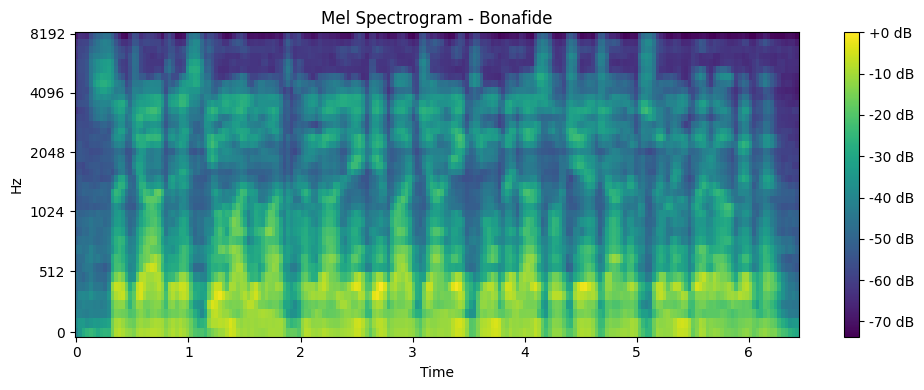

In [10]:
import matplotlib.pyplot as plt
import librosa.display

# Modified function to extract and plot one Mel spectrogram as an example
def extract_and_plot_mel_spectrogram_example(dataset_path, max_length=500):
    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    for file in os.listdir(part_path):
                        file_path = os.path.join(part_path, file)
                        try:
                            # Load and preprocess audio
                            audio, sr = librosa.load(file_path, sr=16000)
                            audio, _ = librosa.effects.trim(audio)  # Trim silent parts

                            # Extract Mel Spectrogram
                            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, fmax=8000)
                            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                            # Plot the spectrogram
                            plt.figure(figsize=(10, 4))
                            librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
                            plt.colorbar(format='%+2.0f dB')
                            plt.title(f"Mel Spectrogram - {category}")
                            plt.tight_layout()
                            plt.show()

                            # Stop after plotting one example
                            return
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
                            continue

# Call the function with your dataset path
extract_and_plot_mel_spectrogram_example('/content/drive/MyDrive/DATASET')


In [11]:
!pip install transformers torch torchvision scikit-learn librosa matplotlib


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import ViTConfig, ViTForImageClassification
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision.transforms as transforms

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import ViTConfig, ViTForImageClassification
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import transforms  # Import necessary for resizing

# Ensure device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Assuming x and y are already prepared as Mel spectrograms and labels
# x: Mel spectrograms (features), y: labels (0 for Bonafide, 1 for Spoofed)

# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to tensors and add channel dimension (1 channel for grayscale)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)[:, None, :, :]
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)[:, None, :, :]
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create a Vision Transformer model from scratch (no pre-trained weights)
config = ViTConfig(
    image_size=224,    # Input image size (Mel spectrograms should be resized to this)
    patch_size=16,     # Size of patches (adjustable based on your data)
    num_channels=1,    # Grayscale images (Mel spectrograms are single channel)
    num_labels=2,      # Number of classes (Bonafide and Spoofed)
    hidden_size=768,   # Hidden dimension size
    num_attention_heads=12,  # Number of attention heads
    num_hidden_layers=12,    # Number of transformer blocks
    intermediate_size=3072,  # Size of intermediate layer in MLP
)

# Instantiate the Vision Transformer model from scratch
vit_model = ViTForImageClassification(config)

# Move model to device (GPU/CPU)
vit_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Resize transformation to match model's input size (224x224)
resize_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert the tensor to PIL image for resizing
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert back to tensor
])


# Training loop
def train_vit_model():
    vit_model.train()
    for epoch in range(7):  # Change epochs as needed
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Resize the inputs using the transform
            inputs = torch.stack([resize_transform(input) for input in inputs]).to(device)  # Move inputs to the same device as model

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = vit_model(inputs).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/7], Loss: {running_loss/len(train_loader):.4f}")


# Evaluate the model
def evaluate_vit_model():
    vit_model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Resize the inputs using the transform
            inputs = torch.stack([resize_transform(input) for input in inputs]).to(device)  # Move inputs to the same device as model

            # Forward pass
            outputs = vit_model(inputs).logits
            _, preds = torch.max(outputs, 1)

            # Store true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


# Run training and evaluation
train_vit_model()
evaluate_vit_model()


Using device: cuda
Epoch [1/7], Loss: 0.8075
Epoch [2/7], Loss: 0.7063
Epoch [3/7], Loss: 0.6981
Epoch [4/7], Loss: 0.6982
Epoch [5/7], Loss: 0.7036
Epoch [6/7], Loss: 0.7025
Epoch [7/7], Loss: 0.6976
Accuracy: 0.5730
Precision: 0.5482
Recall: 0.6646


In [24]:
import torch

# Assuming the model has already been trained (i.e., vit_model and optimizer are already defined)
# Ensure the model is on the right device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

# Save the model and optimizer state dictionaries
def save_trained_model(model, optimizer, path="trained_vit_model.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Trained model saved to {path}")

# Save the model and optimizer state
save_trained_model(vit_model, optimizer, path="trained_vit_model.pth")


Trained model saved to trained_vit_model.pth
